# Third Project: COVID-19 Vaccine Distribution in Fairfield County
## UCONN 5641 Section B13: Business Decision Modeling
### Group 3:
*   Silvanna Moran-Vargas, sim14004
*   Janani Sridhar, jas19055



# Introduction

Nobody could have ever imagined that our life in 2020 would be drastically changed because of the outbreak of the global pandemic Covid-19. This pandemic altered our previous lifestyle in various ways, such as nearly no international travels, regulations of wearing a mask, the transition of working from home, etc. After being on lockdown for more than a half year, we are more than ready to embrace our normal life back to us as the research has shown that more than half of Americans have prayed for an end to the coronavirus’ spread.


Fortunately, many scientists and researchers have been working extremely hard to develop and manufacture effective and safe Covid-19 vaccines to help us fight against the virus and hopefully bring an end to this pandemic. On December 2, 2020, the UK gorvernment first approved the Covid-19 vaccine and announced that the first shots would roll out next week. Therefore, we believe that the US will get the vaccines soon. After obtaining the vaccines, how to deliver vaccines nationwide effectively and efficiently has become a difficult question to discuss.


This project aims to estimate the vaccine shipping cost from three hospitals in CT (Yale New Haven Hospital, Hartford Hospital, Groton/Lawrence and Memorial Hospital) to ten selected towns in Fairfield county under the circumstances that the demand for the vaccines is unknown. Our goal is to minimize the shipping cost so that we can give the government some useful suggestions to distribute sufficient vaccines without spending an unnecessary budget. Since the vaccines' future demand is unknown, we will integrate a Monte Carlo simulation into our analysis to come up with insightful estimates.

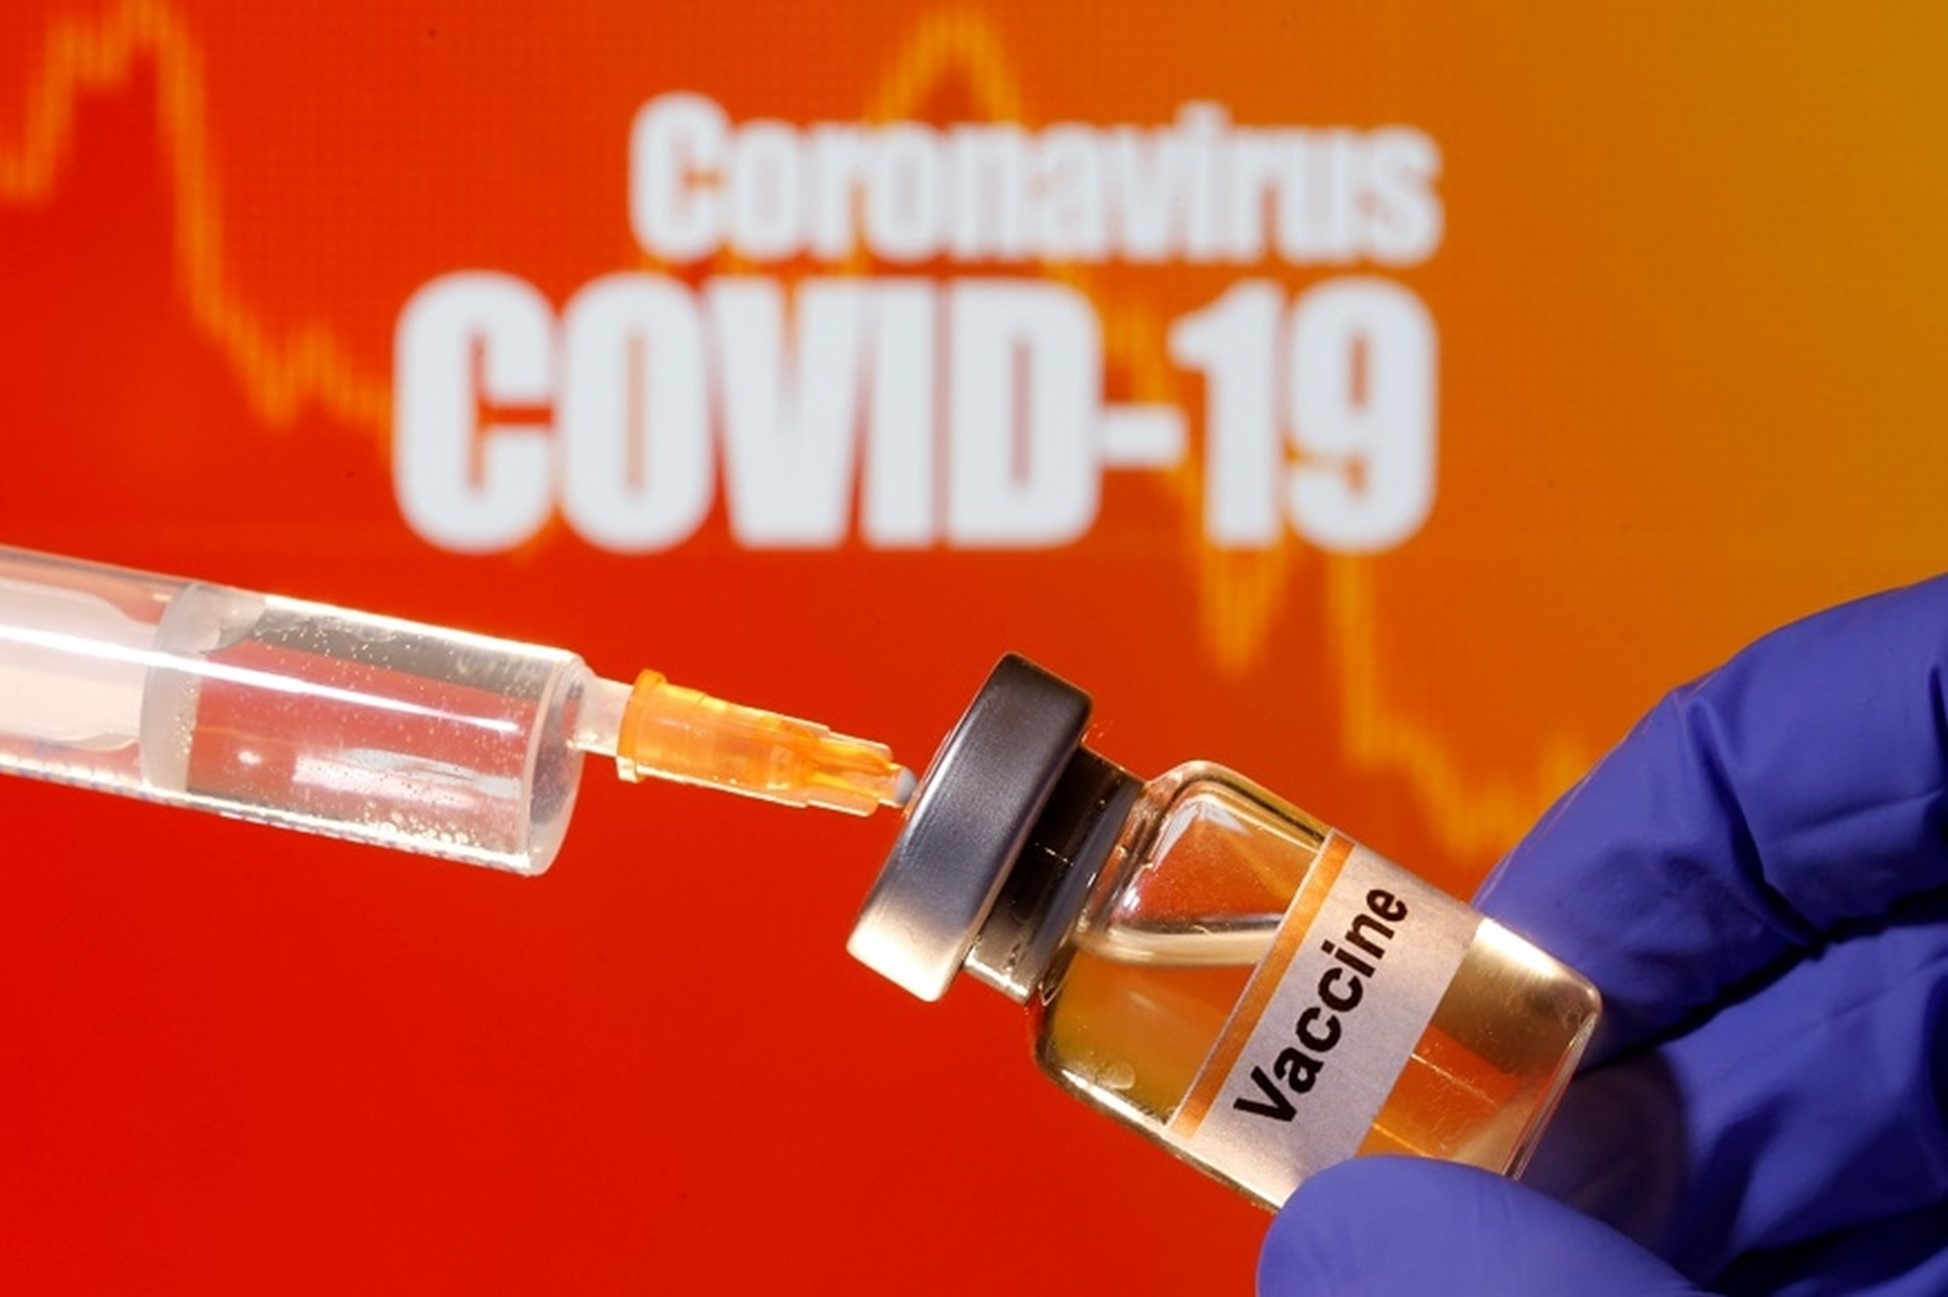

# Import Modules

In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing the required modules
# pandas for data manipulation and numpy for numeric computations
import numpy as np 
import pandas as pd 
# The below modules for data visualization
import matplotlib.pyplot as plt 
import seaborn as sns 
from pylab import * 

In [ ]:
# installing pyomo and ipopt solver
!pip install -q pyomo
from pyomo.environ import *

try:
    import google.colab
    try:
        from pyomo.environ import *
    except:
        !pip install -q pyomo
    if not 'ipopt_executable' in vars():
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
        ipopt_executable = '/content/ipopt'
except:
    pass

# Exploratory Data Analysis
After importing the modules we need so far, it is our time to do some Exploratory Data Analysis, which will include the following parts:



1.   Select ten towns in Fairfield county using data analytics based on demographics information and current Covid-19 statistics.

2.   Get a geographical map to show the ten selected towns and three hospitals.

3.   Calculate the distances between each town and each hospital 

4.   Create a network flow diagram to illustrate the relationship







## Town Selection
We will select ten towns in [Fairfield county](https://en.wikipedia.org/wiki/Fairfield_County,_Connecticut) based on Fairfield county's demographics information and current Covid-19 statistics.

### Fairfield County Demographics

In demographics data, we mainly focused on the **median household income** and **population** because we realized that populous places and low-income regions tend to have a higher infected rate based on our research. 

> **Median household income:**
Some impoverished regions suffered the hardest hit during the pandemic. People who live in low-income areas are at higher risk of serious illness if they are infected with Covid-19 because they may have some underlying health issues and struggle with their financial challenges. Besides, their living conditions may make the virus easy to spread within the neighborhood since some people live cramped together. 

> **Population:**
One of the characteristics of Covid-19 is that it can transmit rapidly among humans. The aerosol transmission has made people easily infected if they have direct or close contact with an infected person. What’s is worse is that some infected people are asymptomatic, resulting in spreading the virus to more people. People usually live relatively close to each other in many populous places, making them more vulnerable to the virus.






In [ ]:
# reading data
df = pd.read_excel('/content/drive/Shareddrives/OPIM 5641/Project 3/Data/FairfieldCities.xlsx')
#viewing the first five rows for understanding the data
df.head()

,Town,Type,Per capita income,Median Household Income,Median Family Income,Population,Number of Households
0,Bethel,Town,36608,83483,99568,18584,6938
1,Bridgeport,City,19854,41047,47894,144229,51255
2,Brookfield,Town,58715,119370,136682,17550,6427
3,Danbury,City,31461,65275,74420,80893,28907
4,Darien,Town,95577,175766,211313,20732,6698


There are about 24 cities and towns in Fairfield county. Our goal is to select 10 cities based on high covid cases or towns having low median household income for vaccine supply by using exploratory data analysis.

In [ ]:
# Subset all rows where 'Type' is equal to 'City' and assign to variable tmp
city = df[df['Type']=='City']
# Print Shape
print(city.shape)
city

(5, 7)


,Town,Type,Per capita income,Median Household Income,Median Family Income,Population,Number of Households
1,Bridgeport,City,19854,41047,47894,144229,51255
3,Danbury,City,31461,65275,74420,80893,28907
13,Norwalk,City,43303,76161,93009,85603,33217
17,Shelton,City,38341,80656,97211,39559,15325
19,Stamford,City,44667,75579,88050,122643,47357


In [ ]:
# sort the dataframe based on Median Household Income
house_income = df.sort_values(by='Median Household Income')
# get some examples of the dataframe
house_income.head(10)

,Town,Type,Per capita income,Median Household Income,Median Family Income,Population,Number of Households
1,Bridgeport,City,19854,41047,47894,144229,51255
3,Danbury,City,31461,65275,74420,80893,28907
18,Stratford,Town,32590,67530,83369,51384,20095
19,Stamford,City,44667,75579,88050,122643,47357
13,Norwalk,City,43303,76161,93009,85603,33217
17,Shelton,City,38341,80656,97211,39559,15325
0,Bethel,Town,36608,83483,99568,18584,6938
10,New Fairfield,Town,39486,101067,108720,13881,4802
20,Trumbull,Town,44006,102059,117855,36018,12725
12,Newtown,Borough,43916,106141,109821,1941,696


Sorting the cities based on low median household income and picking 10 cities which has low income for vaccine supply.

In [ ]:
# sort the dataframe based on Population
pop_data = df.sort_values(by='Population', ascending=False)
# get some examples of the dateframe
pop_data.head(10)

,Town,Type,Per capita income,Median Household Income,Median Family Income,Population,Number of Households
1,Bridgeport,City,19854,41047,47894,144229,51255
19,Stamford,City,44667,75579,88050,122643,47357
13,Norwalk,City,43303,76161,93009,85603,33217
3,Danbury,City,31461,65275,74420,80893,28907
7,Greenwich,Town,92759,124958,167825,61171,23076
6,Fairfield,Town,55733,113248,138067,59404,20457
18,Stratford,Town,32590,67530,83369,51384,20095
17,Shelton,City,38341,80656,97211,39559,15325
20,Trumbull,Town,44006,102059,117855,36018,12725
11,Newtown,Town,45308,108148,120507,27560,9459


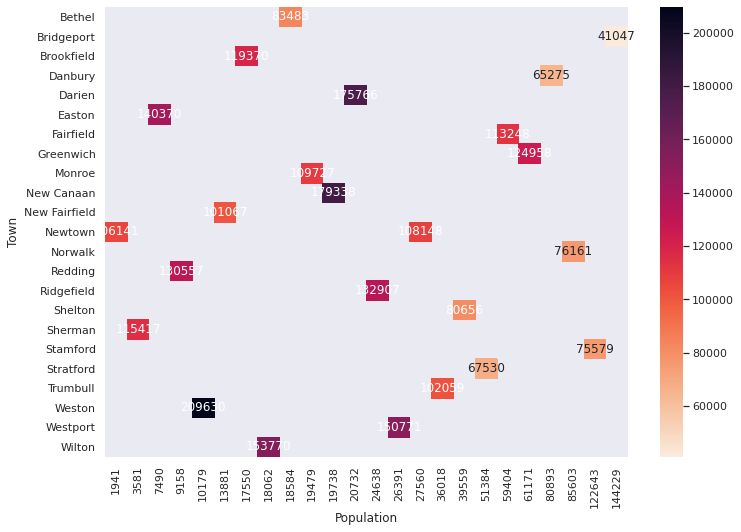

In [ ]:
# create a new dataframe that contains town, population and median household income
town_list = pop_data[['Town', 'Population','Median Household Income']]

# using a heatmap to visualize the information about Population and median household income in each town
result = town_list.pivot(index='Town', columns='Population', values='Median Household Income')
sns.heatmap(result, annot=True, fmt="g", cmap='rocket_r')
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.show()
# therefore, we should choose the squares that close to the right side of the headmap and have a lighter color
# because it means that these towns are poorer and have high population.

**Result 1: Towns selected based on high population size, low Median Household Income as the result of the analytics above**


1.   Bridgeport
2.   Stamford
3. Norwalk
4. Danbury
5.  Greenwich
6. Fairfield
7. Stratford
8. Shelton
9. Trumbull
10. Newtown




### Covid-19 Statistics
In Covid-19 statistics data, we will calculate the current infected rate of each town in this county by using confirmed cases data and population and then select the towns with a high infected rate. We believe that highly infected towns need to have vaccines first, which can help slow down the spread of the virus.

In [ ]:
# reading data
df2 = pd.read_excel('/content/drive/Shareddrives/OPIM 5641/Project 3/Data/COVIDCases.xlsx')
#viewing the first five rows for understanding the data
df2.head()

,Town,Confirmed Cases,Probable Cases
0,Bethel,344,32
1,Bridgeport,4695,163
2,Brookfield,243,15
3,Danbury,3239,159
4,Darien,285,10


In [ ]:
# sort the town based on confirmed cases
case_data = df2.sort_values(by='Confirmed Cases', ascending=False)
# view some examples for this dataframe
case_data.head(10)

,Town,Confirmed Cases,Probable Cases
1,Bridgeport,4695,163
18,Stamford,4045,83
3,Danbury,3239,159
12,Norwalk,2783,65
7,Greenwich,1061,49
6,Fairfield,1054,81
17,Stratford,1040,49
16,Shelton,780,48
19,Trumbull,631,60
21,Westport,411,17


In [ ]:
# merge the dataframe df and df2
#so that the new dataframe pop_case has information on both town basic data and Covid data 
pop_case = pd.merge(df,df2, on='Town')
# view some examples for this dataframe
pop_case.head(5)

,Town,Type,Per capita income,Median Household Income,Median Family Income,Population,Number of Households,Confirmed Cases,Probable Cases
0,Bethel,Town,36608,83483,99568,18584,6938,344,32
1,Bridgeport,City,19854,41047,47894,144229,51255,4695,163
2,Brookfield,Town,58715,119370,136682,17550,6427,243,15
3,Danbury,City,31461,65275,74420,80893,28907,3239,159
4,Darien,Town,95577,175766,211313,20732,6698,285,10


In [ ]:
# create and add a new column "Ratio_percentage" to see the percentage of confirmed cases in each town
pop_case['Ratio_percentage'] = pop_case.apply(
        lambda row: row['Confirmed Cases'] / float(row['Population']),
        axis=1)*100

# sort the new dataframe from higer percentage to lower percentage
# therefore, we can know which towns are more heavily affected by Covid 19 from percentage wise
top_case = pop_case.sort_values('Ratio_percentage', ascending=False)
# view some examples for this dataframe
top_case.head(10)

,Town,Type,Per capita income,Median Household Income,Median Family Income,Population,Number of Households,Confirmed Cases,Probable Cases,Ratio_percentage
12,Newtown,Borough,43916,106141,109821,1941,696,313,21,16.125708
3,Danbury,City,31461,65275,74420,80893,28907,3239,159,4.004055
19,Stamford,City,44667,75579,88050,122643,47357,4045,83,3.298191
1,Bridgeport,City,19854,41047,47894,144229,51255,4695,163,3.255240
13,Norwalk,City,43303,76161,93009,85603,33217,2783,65,3.251054
18,Stratford,Town,32590,67530,83369,51384,20095,1040,49,2.023976
17,Shelton,City,38341,80656,97211,39559,15325,780,48,1.971738
0,Bethel,Town,36608,83483,99568,18584,6938,344,32,1.851055
6,Fairfield,Town,55733,113248,138067,59404,20457,1054,81,1.774291
20,Trumbull,Town,44006,102059,117855,36018,12725,631,60,1.751902


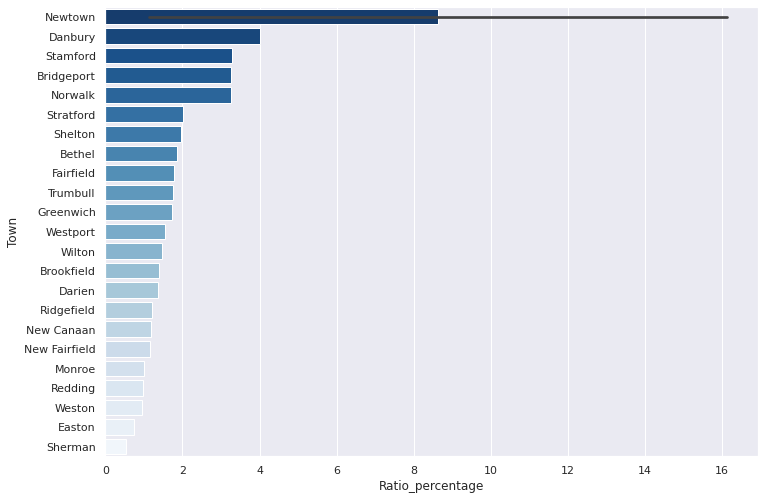

In [ ]:
# create a new dataframe that contains the information of Town and Ratio_percentage
# we can know each town in Fairfield county and the percentage of Covid-19 confirmed cases
ratio_list = top_case[['Town', 'Ratio_percentage']]
ratio_list.head()

# using a barplot to visualize the percentage of Covid-19 confirmed cases in each town
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="Ratio_percentage", y="Town", data=ratio_list,
                 palette="Blues_r")

**Result 2: Towns selected based on the current infected rate as the result of the analytics above**


1.   Newtown
2.   Danbury
3. Stamford
4. Bridgeport
5.  Norwalk
6. Stratford
7. Shelton
8. Bethel
9. Fairfield
10. Trumbull

**Final Selection Result: Ten towns selected based on Median Household Income, Population, and the current infected rate**

1. Bridgeport
2. Stamford
3. Norwalk
4. Danbury
5. Greenwich
6. Fairfield
7. Stratford
8. Shelton
9. Trumbull
10.Newtown

## Map
In this step , we will create a geographical map to show the ten selected towns and three hospitals.

In [ ]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 14 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 

In [ ]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 0s (191 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 144882 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1b

10 Towns Chosen from [Fairfield County](https://en.wikipedia.org/wiki/Fairfield_County,_Connecticut)


1.   Bridgeport
2.   Stamford
3. Norwalk
4. Danbury
5.  Greenwich
6. Fairfield
7. Stratford
8. Shelton
9. Trumbull
10. Newtown


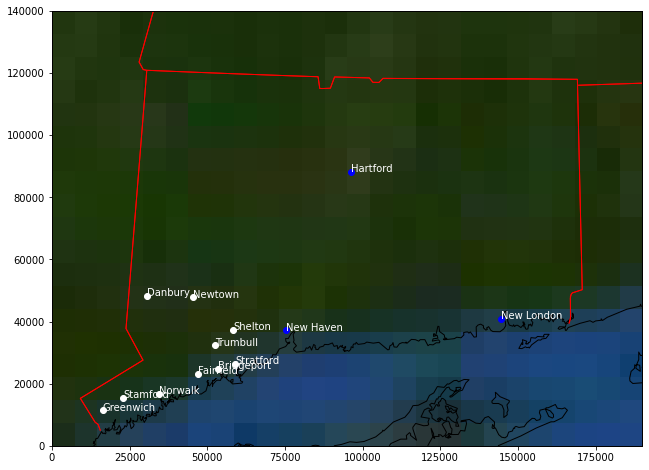

In [ ]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
# resolution = 'c' means use crude resolution coastlines.
fig = plt.figure(figsize=(12,8))
m = Basemap( projection='lcc', resolution='h', 
            lat_0=41.6, lon_0=-72.7,
            width=190000, height=1.4E5, suppress_ticks=False)

# Hartford = 41.763710,-72.685097, New Haven = 41.3044,-72.9356, New London = 41.3363,-72.1046
lat_y_Hf = 41.763710
lon_x_Hf = -72.685097
x,y = m(lon_x_Hf,lat_y_Hf)
m.plot(x,y,'bo')
plt.text(x,y, 'Hartford', fontsize=10,  color='white')
latitudes_y = [41.3044, 41.3363]
longitude_x = [-72.9356, -72.1046]
x,y = m(longitude_x, latitudes_y)
m.plot(x,y,'bo')
plt.text(x[0],y[0], 'New Haven', fontsize=10,  color='white')
plt.text(x[1],y[1], 'New London', fontsize=10,  color='white')

#Counties in CT
lat_y_county = [41.19256154,41.105028,41.1181478,41.40136406,41.06908248,41.17775385,41.20786732,41.30609751,41.26017348,41.39882298]
lon_x_county = [-73.19598675,-73.55903702,-73.4226145,-73.47052706,-73.63846745,-73.27326073,-73.130404,-73.13822123,-73.20842472,-73.29282774]
xCounty,yCounty =  m(lon_x_county, lat_y_county)
m.plot(xCounty,yCounty,'wo')
plt.text(xCounty[0],yCounty[0], 'Bridgeport', fontsize=10,  color='white')
plt.text(xCounty[1],yCounty[1], 'Stamford', fontsize=10,  color='white')
plt.text(xCounty[2],yCounty[2], 'Norwalk', fontsize=10,  color='white')
plt.text(xCounty[3],yCounty[3], 'Danbury', fontsize=10,  color='white')
plt.text(xCounty[4],yCounty[4], 'Greenwich', fontsize=10,  color='white')
plt.text(xCounty[5],yCounty[5], 'Fairfield', fontsize=10,  color='white')
plt.text(xCounty[6],yCounty[6], 'Stratford', fontsize=10,  color='white')
plt.text(xCounty[7],yCounty[7], 'Shelton', fontsize=10,  color='white')
plt.text(xCounty[8],yCounty[8], 'Trumbull', fontsize=10,  color='white')
plt.text(xCounty[9],yCounty[9], 'Newtown', fontsize=10,  color='white')

m.drawcoastlines()
m.drawcountries(linewidth=2.0, linestyle='solid',color='blue')
m.drawstates(linewidth=1.0, linestyle='solid',color='red')
#m.fillcontinents(color='white',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))
m.bluemarble()
#m.etopo()

#m.readshapefile('/content/drive/My Drive/Colab Notebooks/Data/st99_d00', name='states', drawbounds=True)
#m.states_info
m.drawmapboundary(fill_color='aqua')
#plt.title("Miller Cylindrical Projection")
plt.show()

## Distances
Next, we are going to calculate the distances between each town to each hospital.

In [ ]:
# importing the required modules for calculating distances between each town and each hospital
from sklearn.metrics.pairwise import haversine_distances
from math import radians
hartford = [41.7658, -72.6734]
newlondon = [41.3363,-72.1046]
newhaven = [41.3044, -72.9356]
hartford_in_radians = [radians(_) for _ in hartford]
newlondon_in_radians = [radians(_) for _ in newlondon]
newhaven_in_radians = [radians(_) for _ in newhaven]
result = haversine_distances([hartford_in_radians, 
                              newlondon_in_radians,
                              newhaven_in_radians])
result * 6371000/1000  # multiply by Earth radius to get kilometers

array([[ 0.        , 67.23953844, 55.75414246],
       [67.23953844,  0.        , 69.48770789],
       [55.75414246, 69.48770789,  0.        ]])

### Distance from Hartford Hospital
Distribution Site 1. Calculating distance from Hartford hospital to the 10 cities chosen to find the shipping distance.

In [ ]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians
hartfordhosp = [41.7658, -72.6734]
bridgeport = [41.19256154, -73.19598675]
stamford = [41.105028, -73.55903702]
norwalk = [41.1181478, -73.4226145]  
danbury = [41.40136406, -73.47052706]
greenwich = [41.06908248, -73.63846745]
fairfield = [41.17775385, -73.27326073]
stratford = [41.20786732, -73.130404]
shelton = [41.30609751, -73.130404]
trumbull = [41.26017348, -73.20842472]
newtown = [41.39882298, -73.29282774]

hartfordhosp_in_radians = [radians(_) for _ in hartford]
bridgeport_in_radians = [radians(_) for _ in bridgeport]
stamford_in_radians = [radians(_) for _ in stamford]
norwalk_in_radians = [radians(_) for _ in norwalk]
danbury_in_radians = [radians(_) for _ in danbury]
greenwich_in_radians = [radians(_) for _ in greenwich]
fairfield_in_radians = [radians(_) for _ in fairfield]
stratford_in_radians = [radians(_) for _ in stratford]
shelton_in_radians = [radians(_) for _ in shelton]
trumbull_in_radians = [radians(_) for _ in trumbull]
newtown_in_radians = [radians(_) for _ in newtown]

result = haversine_distances([hartfordhosp_in_radians, 
                              bridgeport_in_radians,
                              stamford_in_radians,
                              norwalk_in_radians,
                              danbury_in_radians,
                              greenwich_in_radians,
                              fairfield_in_radians,
                              stratford_in_radians,
                              shelton_in_radians,
                              trumbull_in_radians,
                              newtown_in_radians])
result * 6371000/1000  # multiply by Earth radius to get kilometers

array([[  0.        ,  77.18927275, 104.15870871,  95.32133036,
         77.70219897, 111.70245989,  82.30003686,  72.78689731,
         63.71640303,  71.73220302,  65.72240796],
       [ 77.18927275,   0.        ,  31.91846822,  20.69942497,
         32.63571462,  39.52080214,   6.67290359,   5.74483304,
         13.76380985,   7.58972423,  24.32031175],
       [104.15870871,  31.91846822,   0.        ,  11.521886  ,
         33.77158022,   7.76473182,  25.26019563,  37.66319369,
         42.25748439,  34.03735568,  39.52843148],
       [ 95.32133036,  20.69942497,  11.521886  ,   0.        ,
         31.74584565,  18.89346844,  14.1533819 ,  26.41766092,
         32.15955896,  23.88808944,  33.04148424],
       [ 77.70219897,  32.63571462,  33.77158022,  31.74584565,
          0.        ,  39.52675027,  29.83081052,  35.63846501,
         30.30130306,  26.93371886,  14.8243109 ],
       [111.70245989,  39.52080214,   7.76473182,  18.89346844,
         39.52675027,   0.        ,  32.8

### Distance from New London Hospital
Distribution Site 2. Calculating distance from New London hospital to the 10 cities chosen to find the shipping distance.

In [ ]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians
newlondonhosp = [41.3363, -72.1046]
bridgeport = [41.19256154, -73.19598675]
stamford = [41.105028, -73.55903702]
norwalk = [41.1181478, -73.4226145]  
danbury = [41.40136406, -73.47052706]
greenwich = [41.06908248, -73.63846745]
fairfield = [41.17775385, -73.27326073]
stratford = [41.20786732, -73.130404]
shelton = [41.30609751, -73.130404]
trumbull = [41.26017348, -73.20842472]
newtown = [41.39882298, -73.29282774]

newlondonhosp_in_radians = [radians(_) for _ in newlondonhosp]
bridgeport_in_radians = [radians(_) for _ in bridgeport]
stamford_in_radians = [radians(_) for _ in stamford]
norwalk_in_radians = [radians(_) for _ in norwalk]
danbury_in_radians = [radians(_) for _ in danbury]
greenwich_in_radians = [radians(_) for _ in greenwich]
fairfield_in_radians = [radians(_) for _ in fairfield]
stratford_in_radians = [radians(_) for _ in stratford]
shelton_in_radians = [radians(_) for _ in shelton]
trumbull_in_radians = [radians(_) for _ in trumbull]
newtown_in_radians = [radians(_) for _ in newtown]

result = haversine_distances([newlondonhosp_in_radians, 
                              bridgeport_in_radians,
                              stamford_in_radians,
                              norwalk_in_radians,
                              danbury_in_radians,
                              greenwich_in_radians,
                              fairfield_in_radians,
                              stratford_in_radians,
                              shelton_in_radians,
                              trumbull_in_radians,
                              newtown_in_radians])
result * 6371000/1000  # multiply by Earth radius to get kilometers

array([[  0.        ,  92.60957476, 124.33350383, 112.86180679,
        114.21278593, 131.71840145,  99.26760012,  86.90981963,
         85.72978639,  92.59950598,  99.40043138],
       [ 92.60957476,   0.        ,  31.91846822,  20.69942497,
         32.63571462,  39.52080214,   6.67290359,   5.74483304,
         13.76380985,   7.58972423,  24.32031175],
       [124.33350383,  31.91846822,   0.        ,  11.521886  ,
         33.77158022,   7.76473182,  25.26019563,  37.66319369,
         42.25748439,  34.03735568,  39.52843148],
       [112.86180679,  20.69942497,  11.521886  ,   0.        ,
         31.74584565,  18.89346844,  14.1533819 ,  26.41766092,
         32.15955896,  23.88808944,  33.04148424],
       [114.21278593,  32.63571462,  33.77158022,  31.74584565,
          0.        ,  39.52675027,  29.83081052,  35.63846501,
         30.30130306,  26.93371886,  14.8243109 ],
       [131.71840145,  39.52080214,   7.76473182,  18.89346844,
         39.52675027,   0.        ,  32.8

### Distance from New Haven Hospital
Distribution Site 3.                                                            Calculating distance from New Haven hospital to the 10 cities chosen to find the shipping distance.

In [ ]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians
newhavenhosp = [41.3044, -72.9356]
bridgeport = [41.19256154, -73.19598675]
stamford = [41.105028, -73.55903702]
norwalk = [41.1181478, -73.4226145]  
danbury = [41.40136406, -73.47052706]
greenwich = [41.06908248, -73.63846745]
fairfield = [41.17775385, -73.27326073]
stratford = [41.20786732, -73.130404]
shelton = [41.30609751, -73.130404]
trumbull = [41.26017348, -73.20842472]
newtown = [41.39882298, -73.29282774]

newhavenhosp_in_radians = [radians(_) for _ in newhavenhosp]
bridgeport_in_radians = [radians(_) for _ in bridgeport]
stamford_in_radians = [radians(_) for _ in stamford]
norwalk_in_radians = [radians(_) for _ in norwalk]
danbury_in_radians = [radians(_) for _ in danbury]
greenwich_in_radians = [radians(_) for _ in greenwich]
fairfield_in_radians = [radians(_) for _ in fairfield]
stratford_in_radians = [radians(_) for _ in stratford]
shelton_in_radians = [radians(_) for _ in shelton]
trumbull_in_radians = [radians(_) for _ in trumbull]
newtown_in_radians = [radians(_) for _ in newtown]

result = haversine_distances([newhavenhosp_in_radians, 
                              bridgeport_in_radians,
                              stamford_in_radians,
                              norwalk_in_radians,
                              danbury_in_radians,
                              greenwich_in_radians,
                              fairfield_in_radians,
                              stratford_in_radians,
                              shelton_in_radians,
                              trumbull_in_radians,
                              newtown_in_radians])
result * 6371000/1000  # multiply by Earth radius to get kilometers

array([[ 0.        , 25.07072153, 56.67178709, 45.70083531, 45.93308429,
        64.37456271, 31.54978952, 19.5036811 , 16.27307662, 23.32146756,
        31.61248006],
       [25.07072153,  0.        , 31.91846822, 20.69942497, 32.63571462,
        39.52080214,  6.67290359,  5.74483304, 13.76380985,  7.58972423,
        24.32031175],
       [56.67178709, 31.91846822,  0.        , 11.521886  , 33.77158022,
         7.76473182, 25.26019563, 37.66319369, 42.25748439, 34.03735568,
        39.52843148],
       [45.70083531, 20.69942497, 11.521886  ,  0.        , 31.74584565,
        18.89346844, 14.1533819 , 26.41766092, 32.15955896, 23.88808944,
        33.04148424],
       [45.93308429, 32.63571462, 33.77158022, 31.74584565,  0.        ,
        39.52675027, 29.83081052, 35.63846501, 30.30130306, 26.93371886,
        14.8243109 ],
       [64.37456271, 39.52080214,  7.76473182, 18.89346844, 39.52675027,
         0.        , 32.89074495, 45.25907989, 50.02094139, 41.80194364,
        46.687

## Network Graph
The final part of this EDA is to create a network flow diagram to illustrate and visualize the relationships among the hospitals and towns.

In [ ]:
# importing the required modules to build a network graph
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

N = ['Y','H','L']
E = ['B', 'S','NO','D','G','F','SF','SH','T','N']
G = nx.DiGraph()
G.add_nodes_from(N)
G.add_edges_from([('Y', 'B'), ('Y', 'S'), ('Y', 'NO'),('Y', 'D'), ('Y', 'G'), ('Y', 'F'),
                  ('Y','SF'),('Y','SH'),('Y','T'),('Y','N'),
                  ('H', 'B'), ('H', 'S'), ('H', 'NO'),('H', 'D'), ('H', 'G'), ('H', 'F'),
                  ('H','SF'),('H','SH'),('H','T'),('H','N'),
                  ('L', 'B'), ('L', 'S'), ('L', 'NO'),('L', 'D'), ('L', 'G'), ('L', 'F'),
                  ('L','SF'),('L','SH'),('L','T'),('L','N')])

labels = {'B':'Bridgeport', 'S':'Stamford', 'NO':'Norwalk', 'D':'Danbury',
          'G':'Greenwich','F':'Fairfield','SF':'Stratford','SH':'Shelton',
          'T':'Trumbell','N':'Newtown',
          'Y':'Yale','H':'Hartford','L':'New London'}

<Figure size 800x640 with 0 Axes>

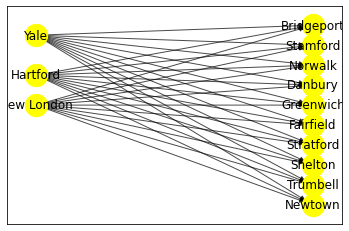

In [ ]:
# Need to create a layout when doing
# separate calls to draw nodes and edges
fixed_positions = {'Y':(1, 300),'H':(1, 100),'L':(1, -50) ,'B':(5, 350),'S':(5, 250),'NO':(5, 150),'D':(5, 50),
                   'G':(5,-50),'F':(5,-150),'SF':(5,-250),'SH':(5,-350),'T':(5,-450),'N':(5,-550)} 
fixed_nodes = fixed_positions.keys() 

pos = nx.spring_layout(G, k=2, pos=fixed_positions  ,fixed=fixed_nodes, iterations=100, threshold=0.0001, weight='weight', scale=1, center= [0,100], dim=2)
nx.draw_networkx_labels(G, pos, labels=labels)
nx.draw_networkx_nodes(G, pos=fixed_positions,  node_size = 500, node_color= '#FFFF00', )
nx.draw_networkx_edges(G, pos, arrows=True, arrowsize= 10, alpha=0.7, min_target_margin=5)

plt.show()

# Part 1

**Set of arcs in the network**

$A = \{YH\_B,YH\_S,YH\_NO,YH\_D,YH\_G,YH\_SF,YH\_SH,YH\_T,YH\_NT,HH\_B,HH\_S,HH\_NO,HH\_D,HH\_G,HH\_SF,HH\_SH,HH\_T,HH\_NT,NL\_B,NL\_S,NL\_NO,NL\_D,NL\_G,NL\_SF,NL\_SH,NL\_T,NL\_NT\}$


**Objective Function**

$\min \sum\limits_{a \in A} c_a \cdot x_a$ `(objective function)`



## Network Model 1
**Minimum Cost Flow**

In [ ]:
# Install Packages
%matplotlib inline
from pylab import *

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

from pyomo.environ import *
# ensure you have cbc installed
!apt-get install -y -qq coinor-cbc

Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 144898 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.10.14+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.10.14+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.107.9+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.107.9+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.16.11+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.16.11+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.59.10+repack1-1_amd64.deb ...
Unpacking coinor-libcgl1 (0.59.10+repack1-1) ...
Selecting previously unselected package coinor-libcbc3.
Preparing to unpack .../4-coinor-libcbc3_2.9.9+repack1-1_amd64.deb ...
Unpacking coinor-libcbc3 (2.9.9+repack1-1) ...
Selecting p

In [ ]:
# Check to see if we have enough supply for demand:
DEM = 4695 + 4045 + 2783 + 3239 + 1061 + 1054 + 1040 + 780 + 631 + 313
SUP = 10000000 + 10000000 + 10000000
SUP - DEM

29980359

We do have enough total supply for total demand in our county.

In [ ]:
# Create dictionaries to store variables
# Demand dictionary which stores demand of 10 towns
Demand = {
    'B': 4695,
    'S': 4045,
    'NO': 2783,
    'D': 3239,
    'G': 1061,
    'F': 1054,
    'SF': 1040,
    'SH': 780,
    'T': 631,
    'N': 313
}

# Supply dictionary for supply of 3 hospitals
Supply = {
    'HH': 1000000,
    'NL': 1000000,
    'NH': 1000000,
}

# TC = total costs (1 km = $1), dictionary that stores the cost of transportation (total cost)
TC = {
    ('B','HH'): 77.18927275,
    ('B','NL'): 92.60957476,
    ('B','NH'): 25.07072153,
    ('S','HH'): 104.15870871,
    ('S','NL'): 124.33350383,
    ('S','NH'): 56.67178709,
    ('NO','HH'): 95.32133035,
    ('NO','NL'): 112.86189679,
    ('NO','NH'): 45.70083531,
    ('D','HH'): 77.70219897,
    ('D','NL'): 114.21278593,
    ('D','NH'): 45.93308429,
    ('G','HH'): 111.70245989,
    ('G','NL'): 131.71840145,
    ('G','NH'): 64.37456271,
    ('F','HH'): 82.30003686,
    ('F','NL'): 99.26760012,
    ('F','NH'): 31.54978952,
    ('SF','HH'): 72.78689731,
    ('SF','NL'): 86.90981963,
    ('SF','NH'): 19.5036811,
    ('SH','HH'): 63.71640303,
    ('SH','NL'): 85.72978639,
    ('SH','NH'): 16.27307662,
    ('T','HH'): 71.73220302,
    ('T','NL'): 92.59950598,
    ('T','NH'): 23.32146756,
    ('N','HH'): 65.72240796,
    ('N','NL'): 99.40043138,
    ('N','NH'): 31.61248006
}

In [ ]:
# Create variable that calculates 30% of the total demand (use this for one of the constraints)
totaldemand = sum(list(Demand.values()))
thirddemand = totaldemand*0.3
thirddemand

5892.3

In [ ]:
# Define the model
# Step 0: Create an instance of the model
model = ConcreteModel()

# Step 1: Define index sets
CUS = list(Demand.keys()) # CUS is for customers (demand)
SRC = list(Supply.keys()) # SRC is for source (supply/capcity)

# Step 2: Define the decision
model.x = Var(CUS, SRC, domain = NonNegativeIntegers)

In [ ]:
# Step 3: Define Objective
model.Cost = Objective(
    expr = sum([TC[c,s]*model.x[c,s] for c in CUS for s in SRC]),
    sense = minimize)

In [ ]:
# Step 4: Add Constraints
# Making sure that we stay within the supply amount
model.src = ConstraintList()
for s in SRC:
    model.src.add(sum([model.x[c,s] for c in CUS]) <= Supply[s])

# Vaccines have to meet demand        
model.dmd = ConstraintList()
for c in CUS:
    model.dmd.add(sum([model.x[c,s] for s in SRC]) >= Demand[c])

# Each hospital must supply at least 30% of county demand
# County demand = 19641, 19641*0.3 = 5892.3
# Each hospital must supply at least 5893 vaccines
model.minsup = ConstraintList()
for s in SRC:
    model.src.add(sum([model.x[c,s] for c in CUS]) >= thirddemand)

In [ ]:
# Print model
model.pprint()

6 Set Declarations
    dmd_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
    minsup_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    0 :      {}
    src_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    6 : {1, 2, 3, 4, 5, 6}
    x_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : x_index_0*x_index_1 :   30 : {('B', 'HH'), ('B', 'NL'), ('B', 'NH'), ('S', 'HH'), ('S', 'NL'), ('S', 'NH'), ('NO', 'HH'), ('NO', 'NL'), ('NO', 'NH'), ('D', 'HH'), ('D', 'NL'), ('D', 'NH'), ('G', 'HH'), ('G', 'NL'), ('G', 'NH'), ('F', 'HH'), ('F', 'NL'), ('F', 'NH'), ('SF', 'HH'), ('SF', 'NL'), ('SF', 'NH'), ('SH', 'HH'), ('SH', 'NL'), ('SH', 'NH'), ('T', 'HH'), ('T',

In [ ]:
# Solve the model and show results
results = SolverFactory('cbc').solve(model)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1403368.95374366
  Upper bound: 1403368.95374366
  Number of objectives: 1
  Number of constraints: 16
  Number of variables: 30
  Number of binary variables: 0
  Number of integer variables: 30
  Number of nonzeros: 30
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.01
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 

In [ ]:
# Print the total cost (transportation cost)
model.Cost()

1403368.95374366

In [ ]:
# Print the solution for how much goes in each node 
# Only print nodes which are greater than 0
for c in CUS:
    for s in SRC:
        if model.x[c,s]() > 0:
          print(c, s, model.x[c,s]())

B NL 1009.0
B NH 3686.0
S HH 1561.0
S NH 2484.0
NO NL 2783.0
D HH 3239.0
G NL 1061.0
F NH 1054.0
SF NL 1040.0
SH HH 780.0
T NH 631.0
N HH 313.0


**Final Cost**

The total cost of vaccines to satisfy each town's demand is: $\$1,403,369$

**Final Solution:**


1.   Bridgeport
  * New London $=1009$
  * New Haven $=3686$
2. Stamford
  * Hartford $=1561$
  * New Haven $=2484$
3. Norwalk
  * New London $=2783$
4. Danbury
  * Hartford $=3239$
5. Greenwich
  * New London $=1061$
6. Fairfield
  * New Haven $=1054$
7. Stratford
  * New London $=1040$
8. Shelton
  * Hartford $=780$
9. Trumbull
  * New Haven $=631$
10. Newtown
  * Hartford $=313$





**Counts for Each Hospital**

30% of total demand $=5892.3$

we see below that all our hospitals satisfied the 30% demand constraint. Every hospital can supply atleast 5893.
*   Yale New Haven Hospital $=7855$
*   Hartford Hospital $=5893$
*   New London Hospital $=5893$



## Monte Carlo Simulation 1

In [ ]:
# Import modules
import numpy as np
import seaborn as sns # for plotting
import matplotlib.pyplot as plt # for plotting
from pylab import * # for plotting

**Demand Triangular Distribution**

Minimum = $Demand\ today$ 

Maximum = $5 * Demand\ today$

Mode = $2 * Demand\ today$ 

Iterations = 10,000

In [ ]:
# Create array with demand today which will be used in triangular distribution as min demand
towndemand = (4695, 4045, 2783, 3239, 1061, 1054, 1040, 780, 631, 313)
mintowndemand = np.array(towndemand)
mintowndemand

array([4695, 4045, 2783, 3239, 1061, 1054, 1040,  780,  631,  313])

In [ ]:
# Calculate the max demand by multiplying mintowndemand by 5
maxtowndemand = mintowndemand * 5 
print(maxtowndemand)

[23475 20225 13915 16195  5305  5270  5200  3900  3155  1565]


In [ ]:
# Calculate the mode of demand by multiplying mintowndemand by 2
modetowndemand = mintowndemand * 2
print(modetowndemand)

[9390 8090 5566 6478 2122 2108 2080 1560 1262  626]


In [ ]:
# Store the 10k results for demand
resultDF_10K = [] 
# Store the 10k results for cost
costDF_10K = []

# Create for loop for 10000 iterations
for a in np.arange(10000):
  # Empty lists to add the demand and cost
    resultDF = []
    costDF = []

    # Create triangular distribution for each town's demands
    DemandB = np.random.triangular(4695, 9390, 23475, size=1)
    DemandS = np.random.triangular(4045, 8090, 20225, size=1)
    DemandNO = np.random.triangular(2783, 5566, 13915, size=1)
    DemandD = np.random.triangular(3239, 6478, 16195, size=1)
    DemandG = np.random.triangular(1061, 2122, 5305, size=1)
    DemandF = np.random.triangular(1054, 2108, 5270, size=1)
    DemandSF = np.random.triangular(1040, 2080, 5200, size=1)
    DemandSH = np.random.triangular(780, 1560, 3900, size=1)
    DemandT = np.random.triangular(631, 1262, 3155, size=1)
    DemandN = np.random.triangular(313, 626, 1565, size=1)

    # Store demands for each town in dictionary as integers
    Demand = {
      'B': int(DemandB),
      'S': int(DemandS),
      'NO': int(DemandNO),
      'D': int(DemandD),
      'G': int(DemandG),
      'F': int(DemandF),
      'SF': int(DemandSF),
      'SH': int(DemandSH),
      'T': int(DemandT),
      'N': int(DemandN)
    }

    # Sum the demand of each town
    sumDemand = sum(list(Demand.values()))
    # Calculate 30% of total demand (to be used for a constraint)
    thirddemand = sumDemand*0.3

    # Same optimization model as Network Model 1 section
    model = ConcreteModel()
    # Step 1: Define index sets
    CUS = list(Demand.keys()) # CUS is for customers (demand)
    SRC = list(Supply.keys()) # SRC is for source (supply/capcity)
    # Step 2: Define the decision 
    model.x = Var(CUS, SRC, domain = NonNegativeIntegers)
    model.Cost = Objective(
      expr = sum([TC[c,s]*model.x[c,s] for c in CUS for s in SRC]),
      sense = minimize)
    # Step 4: Add Constraints
    model.src = ConstraintList()
    for s in SRC:
      model.src.add(sum([model.x[c,s] for c in CUS]) <= Supply[s])   
    model.dmd = ConstraintList()
    for c in CUS:
      model.dmd.add(sum([model.x[c,s] for s in SRC]) >= Demand[c])
    model.minsup = ConstraintList()
    for s in SRC:
      model.src.add(sum([model.x[c,s] for c in CUS]) >= thirddemand)

    results = SolverFactory('cbc').solve(model)
    results.write()

    resultDF = np.append(resultDF, sumDemand)
    costDF = np.append(costDF, model.Cost())
    print('Results:', results)

  # This is in the 10k loop
    resultDF = np.sum(resultDF) # Overwriting resultDF
    costDF = np.sum(costDF)  # Overwriting costDF
    # Print number of iterations, demand and cost for each iteration
    print('Iteration:',a)
    print('Demand:', resultDF)
    print('Cost:', model.Cost())
  # Store 10000 values for demand and cost
    resultDF_10K = np.append(resultDF_10K, resultDF)
    costDF_10K = np.append(costDF_10K, costDF)


Streaming output truncated to the last 5000 lines.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
    Black box: 
      Number of iterations: 2
  Error rc: 0
  Time: 0.05260157585144043
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Results: 
Problem: 
- Name: unknown
  Lower bound: 3401190.36522042
  Upper bound: 3401190.36522042
  Number of objectives: 1
  Number of constraints: 16
  Number of variables: 30
  Number of binary variables: 0
  Number of integer variables: 30
  Number of nonzeros: 30
  Sense: minimize
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.01
  Ter

## Analysis Part 1

### Distribution of Cost
Probabilistic Density Function

In [ ]:
# Check to make sure all 10000 iterations were stored for cost
print(costDF_10K.shape)
# See overview of values to check
costDF_10K

(10000,)


array([3600040.99098797, 3593088.11111109, 3614621.37693914, ...,
       2674738.17613264, 4126370.6604356 , 3462163.35878106])

In [ ]:
# Calculate mean of the distribution of cost
np.mean(costDF_10K)

3744860.0003598235

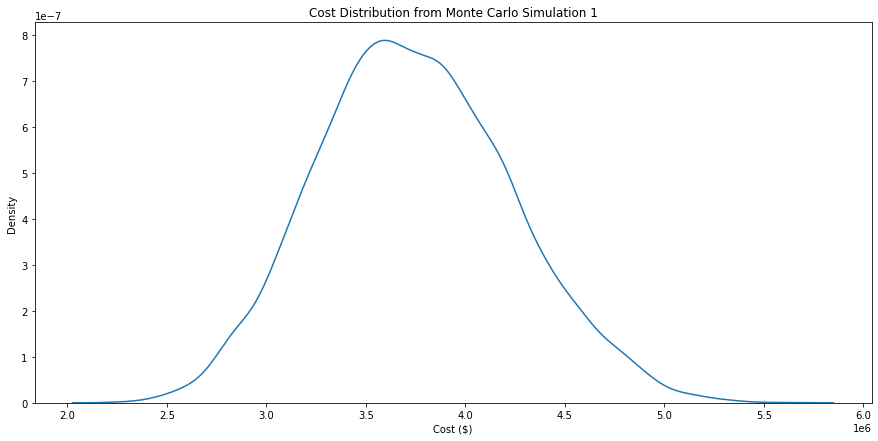

In [ ]:
# Visualize the distribution of cost values
sns.kdeplot(costDF_10K)
plt.title('Cost Distribution from Monte Carlo Simulation 1')
xlabel('Cost ($)')
ylabel('Density')
plt.gcf().set_size_inches((15, 7))
plt.show() 

### Distribution of Cases
Probabilistic Density Function

In [ ]:
# Check to make sure all 10000 iterations were stored for cases
print(resultDF_10K.shape)
# See overview of values to check
resultDF_10K

(10000,)


array([49665., 49902., 48183., ..., 38459., 57214., 48491.])

In [ ]:
# Calculate mean of case distribution
np.mean(resultDF_10K)

52431.101

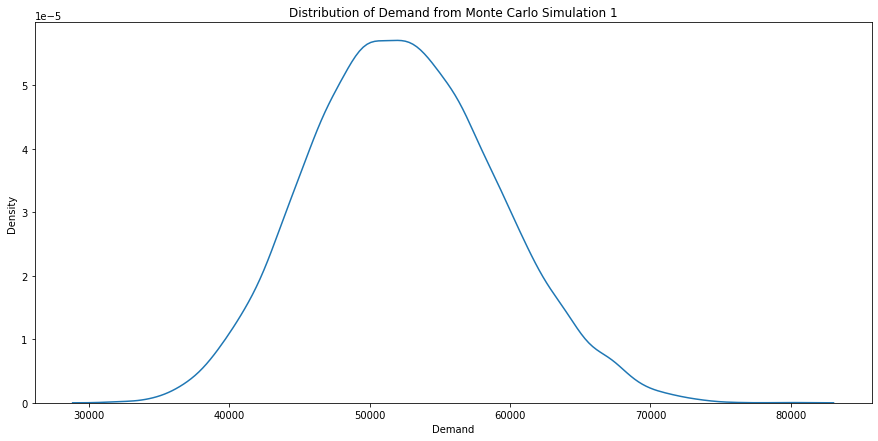

In [ ]:
# Visualize the distribution of case values
sns.kdeplot(resultDF_10K)
plt.title('Distribution of Demand from Monte Carlo Simulation 1')
xlabel('Demand')
ylabel('Density')
plt.gcf().set_size_inches((15, 7))
plt.show() 

# Part 2

**Set of arcs in the network**

$A = \{YH\_B,YH\_S,YH\_NO,YH\_D,YH\_G,YH\_SF,YH\_SH,YH\_T,YH\_NT,HH\_B,HH\_S,HH\_NO,HH\_D,HH\_G,HH\_SF,HH\_SH,HH\_T,HH\_NT,NL\_B,NL\_S,NL\_NO,NL\_D,NL\_G,NL\_SF,NL\_SH,NL\_T,NL\_NT\}$


**Objective Function**

$\min \sum\limits_{a \in A} c_a \cdot x_a$ `(objective function)`



## Network Model 2
**Minimum Cost Flow**

In [ ]:
# Create dictionaries to store variables
# Demand dictionary which stores demand of 10 towns
Demand = {
    'B': 4695,
    'S': 4045,
    'NO': 2783,
    'D': 3239,
    'G': 1061,
    'F': 1054,
    'SF': 1040,
    'SH': 780,
    'T': 631,
    'N': 313
}

# Supply dictionary for supply of 3 hospitals
Supply = {
    'HH': 1000000,
    'NL': 1000000,
    'NH': 1000000,
}

# TC = total costs (1 km = $1), dictionary that stores the cost of transportation (total cost)
TC = {
    ('B','HH'): 77.18927275,
    ('B','NL'): 92.60957476,
    ('B','NH'): 25.07072153,
    ('S','HH'): 104.15870871,
    ('S','NL'): 124.33350383,
    ('S','NH'): 56.67178709,
    ('NO','HH'): 95.32133035,
    ('NO','NL'): 112.86189679,
    ('NO','NH'): 45.70083531,
    ('D','HH'): 77.70219897,
    ('D','NL'): 114.21278593,
    ('D','NH'): 45.93308429,
    ('G','HH'): 111.70245989,
    ('G','NL'): 131.71840145,
    ('G','NH'): 64.37456271,
    ('F','HH'): 82.30003686,
    ('F','NL'): 99.26760012,
    ('F','NH'): 31.54978952,
    ('SF','HH'): 72.78689731,
    ('SF','NL'): 86.90981963,
    ('SF','NH'): 19.5036811,
    ('SH','HH'): 63.71640303,
    ('SH','NL'): 85.72978639,
    ('SH','NH'): 16.27307662,
    ('T','HH'): 71.73220302,
    ('T','NL'): 92.59950598,
    ('T','NH'): 23.32146756,
    ('N','HH'): 65.72240796,
    ('N','NL'): 99.40043138,
    ('N','NH'): 31.61248006
}

In [ ]:
# Create variable that calculates 10% of the total demand (use this for one of the constraints)
totaldemand = sum(list(Demand.values()))
tenthdemand = totaldemand*0.1
tenthdemand

1964.1000000000001

In [ ]:
# Define the model
# Step 0: Create an instance of the model
model2 = ConcreteModel()

# Step 1: Define index sets
CUS = list(Demand.keys()) # CUS is for customers (demand)
SRC = list(Supply.keys()) # SRC is for source (supply/capcity)

# Step 2: Define the decision 
model2.x = Var(CUS, SRC, domain = NonNegativeIntegers)

In [ ]:
# Step 3: Define Objective
model2.Cost = Objective(
    expr = sum([TC[c,s]*model2.x[c,s] for c in CUS for s in SRC]),
    sense = minimize)

In [ ]:
# Step 4: Add Constraints using for loops
# Vaccine amount does not exceed total supply
model2.src = ConstraintList()
for s in SRC:
    model2.src.add(sum([model2.x[c,s] for c in CUS]) <= Supply[s])

# Meet demand        
model2.dmd = ConstraintList()
for c in CUS:
    model2.dmd.add(sum([model2.x[c,s] for s in SRC]) >= Demand[c])

# Each hospital must supply at least 10% of county demand
# County demand = 19641, 19641*0.1 = 1964.1
# Each hospital must supply at least 1965 vaccines
model2.minsup = ConstraintList()
for s in SRC:
    model2.src.add(sum([model2.x[c,s] for c in CUS]) >= tenthdemand)

In [ ]:
# Print model
model2.pprint()

6 Set Declarations
    dmd_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
    minsup_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    0 :      {}
    src_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    6 : {1, 2, 3, 4, 5, 6}
    x_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : x_index_0*x_index_1 :   30 : {('B', 'HH'), ('B', 'NL'), ('B', 'NH'), ('S', 'HH'), ('S', 'NL'), ('S', 'NH'), ('NO', 'HH'), ('NO', 'NL'), ('NO', 'NH'), ('D', 'HH'), ('D', 'NL'), ('D', 'NH'), ('G', 'HH'), ('G', 'NL'), ('G', 'NH'), ('F', 'HH'), ('F', 'NL'), ('F', 'NH'), ('SF', 'HH'), ('SF', 'NL'), ('SF', 'NH'), ('SH', 'HH'), ('SH', 'NL'), ('SH', 'NH'), ('T', 'HH'), ('T',

In [ ]:
# Solve the model and show results
results = SolverFactory('cbc').solve(model2)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 976447.16678597
  Upper bound: 976447.16678597
  Number of objectives: 1
  Number of constraints: 16
  Number of variables: 30
  Number of binary variables: 0
  Number of integer variables: 30
  Number of nonzeros: 30
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.02
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
 

In [ ]:
# Print the total cost of transporting demand to each town in county
model2.Cost()

976447.16678597

In [ ]:
# Print the solution for how much goes in each node
# Only print nodes greater than 0 
for c in CUS:
    for s in SRC:
        if model2.x[c,s]() > 0:
          print(c, s, model2.x[c,s]())

B NH 4695.0
S NH 4045.0
NO NL 1965.0
NO NH 818.0
D HH 1965.0
D NH 1274.0
G NH 1061.0
F NH 1054.0
SF NH 1040.0
SH NH 780.0
T NH 631.0
N NH 313.0


**Final Cost**

The total cost of vaccines to satisfy each town's demand is: $\$976,448$

**Final Solution:**


1.   Bridgeport
  * New Haven $=4695$
2. Stamford
  * New Haven $=4045$
3. Norwalk
  * New London $=1965$
  * New Haven $=818$
4. Danbury
  * Hartford $=1965$
  * New Haven $=1274$
5. Greenwich
  * New Haven $=1061$
6. Fairfield
  * New Haven $=1054$
7. Stratford
  * New Haven $=1040$
8. Shelton
  * New Haven $=780$
9. Trumbull
  * New Haven $=631$
10. Newtown
  * New Haven $=313$





**Counts for Each Hospital**

10% of total demand $=1964.1$


*   Yale New Haven Hospital $=14,437$
*   Hartford Hospital $=1965$
*   New London Hospital $=1965$



## Monte Carlo Simulation 2

Each hospital provides 10% of demand

In [ ]:
# Store the 10k results for demand
resultDF2_10K = ([]) # this is where we will store the 10k results
# Store the 10k results for cost
costDF2_10K = ([])

# Create for loop for 10k iterations
for a in np.arange(10000):
    # Empty lists to add the demand and cost
    resultDF2 = []
    costDF2 = []

    # Create triangular distribution for each town's demands
    DemandB = np.random.triangular(4695, 9390, 23475, size=1)
    DemandS = np.random.triangular(4045, 8090, 20225, size=1)
    DemandNO = np.random.triangular(2783, 5566, 13915, size=1)
    DemandD = np.random.triangular(3239, 6478, 16195, size=1)
    DemandG = np.random.triangular(1061, 2122, 5305, size=1)
    DemandF = np.random.triangular(1054, 2108, 5270, size=1)
    DemandSF = np.random.triangular(1040, 2080, 5200, size=1)
    DemandSH = np.random.triangular(780, 1560, 3900, size=1)
    DemandT = np.random.triangular(631, 1262, 3155, size=1)
    DemandN = np.random.triangular(313, 626, 1565, size=1)

    # Store demands for each town in dictionary as integers
    Demand = {
      'B': int(DemandB),
      'S': int(DemandS),
      'NO': int(DemandNO),
      'D': int(DemandD),
      'G': int(DemandG),
      'F': int(DemandF),
      'SF': int(DemandSF),
      'SH': int(DemandSH),
      'T': int(DemandT),
      'N': int(DemandN)
    }

    # Sum the demand of each town
    sumDemand = sum(list(Demand.values()))
    # Calculate 10% of total demand (to be used for a constraint)
    tenthdemand = sumDemand*0.10

    # Same optimization model as the one created for Network Model 2
    model = ConcreteModel()
    # Step 1: Define index sets
    CUS = list(Demand.keys()) # CUS is for customers (demand)
    SRC = list(Supply.keys()) # SRC is for source (supply/capcity)
    # Step 2: Define the decision 
    model.x = Var(CUS, SRC, domain = NonNegativeIntegers)
    model.Cost = Objective(
      expr = sum([TC[c,s]*model.x[c,s] for c in CUS for s in SRC]),
      sense = minimize)
    # Step 4: Add Constraints (note the ease in which this happens with for loops!)
    model.src = ConstraintList()
    for s in SRC:
      model.src.add(sum([model.x[c,s] for c in CUS]) <= Supply[s])   
    model.dmd = ConstraintList()
    for c in CUS:
      model.dmd.add(sum([model.x[c,s] for s in SRC]) >= Demand[c])
    model.minsup = ConstraintList()
    for s in SRC:
      model.src.add(sum([model.x[c,s] for c in CUS]) >= tenthdemand)

    results = SolverFactory('cbc').solve(model)
    results.write()

    resultDF2 = np.append(resultDF2, sumDemand)
    costDF2 = np.append(costDF2, model.Cost())
    # Print model results
    print('Results:', results)


  # This is in the 10k loop
    resultDF2 = np.sum(resultDF2) # Overwriting resultDF
    costDF2 = np.sum(costDF2) # Overwriting costDF2
    # Print iteration, demand and cost for each iteration
    print('Iteration:',a)
    print('Demand:', resultDF2)
    print('Cost:', model.Cost())
  # store values for demand and cost of 10k iterations 
    resultDF2_10K = np.append(resultDF2_10K, resultDF2)
    costDF2_10K = np.append(costDF2_10K, costDF2)

Streaming output truncated to the last 5000 lines.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
    Black box: 
      Number of iterations: 2
  Error rc: 0
  Time: 0.052790164947509766
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Results: 
Problem: 
- Name: unknown
  Lower bound: 3270533.53387577
  Upper bound: 3270533.53387577
  Number of objectives: 1
  Number of constraints: 16
  Number of variables: 30
  Number of binary variables: 0
  Number of integer variables: 30
  Number of nonzeros: 30
  Sense: minimize
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.01
  Te

## Analysis Part 2

### Distribution of Cost
Probabilistic Density Function

In [ ]:
# Check to make sure all 10000 iterations were stored for cost
print(costDF2_10K.shape) 
# See overview of values to check
costDF2_10K

(10000,)


array([2788103.18800244, 2381056.33548817, 2522861.98648942, ...,
       2770444.4350453 , 2397972.29856993, 2227700.75238749])

In [ ]:
# Calculate mean of the distribution of cost
np.mean(costDF2_10K)

2598916.3068747236

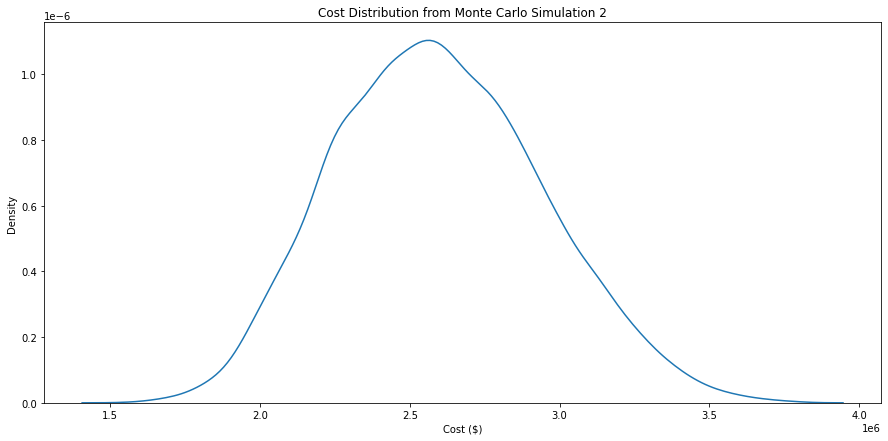

In [ ]:
# Visualize the distribution of cost values
sns.kdeplot(costDF2_10K)
plt.title('Cost Distribution from Monte Carlo Simulation 2')
xlabel('Cost ($)')
ylabel('Density')
plt.gcf().set_size_inches((15, 7))
plt.show() 

### Distribution of Cases
Probabilistic Density Function

In [ ]:
# Check to make sure all 10000 iterations were stored for cases
print(resultDF2_10K.shape)
# See overview of values to check
resultDF2_10K

(10000,)


array([56928., 47426., 53434., ..., 55841., 47975., 44223.])

In [ ]:
# Calculate mean of case distribution
np.mean(resultDF2_10K)

52279.3308

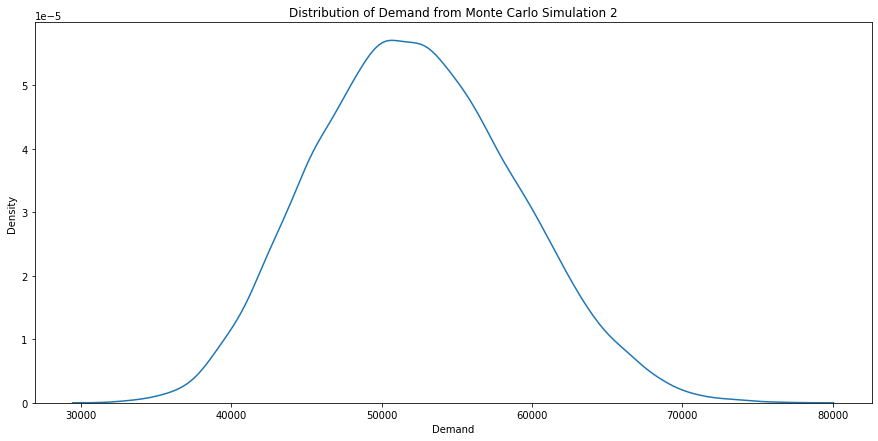

In [ ]:
# Visualize the distribution of case values
sns.kdeplot(resultDF2_10K)
plt.title('Distribution of Demand from Monte Carlo Simulation 2')
xlabel('Demand')
ylabel('Density')
plt.gcf().set_size_inches((15, 7))
plt.show() 

# Written Analysis

For the first Network Model where each hospital needed to provide at least 30% of total demand, the hospital that proved to "best fit" the model was Yale New Haven Hospital. This finding was further backed up by the second Network Model where each hospital only needed to provide 10% of the total demand. Since the cost of the vaccine was based on transportation alone, the reason why it was the "best fit" is because Yale New Haven Hospital is the closest in distance to our county. For both the first and second Network Models Hartford Hospital and New London Hospital were only used because of the constraint that required at least 30% or 10% of the demand to come from each. In both models each met the demand but did not account for more because they were not optimal for minimizing cost.

In the first network model the cost totaled to be $\$1,403,369$ and in the second model the cost was $\$976,448$. Clearly, reducing the constraint for minimum number of supply from each hospital from 30% to 10% decreased the cost of transporting the vaccines by nearly half a million dollars. 

Using a Monte Carlo simulations for each model we attempted to predict demand for the vaccines and cost a month from today. We found the distrubution of the total cost of the vaccines after using a triangular distribution on the vaccine demand where:
* Minimum = $Demand\ today$ 
* Mode = $2 * Demand\ today$ 
* Maximum = $5 * Demand\ today$

In the simulation we ran 10,000 iterations and stored the results to plot probabilistic density functions for both demand and cost. The mean for the first model for cost was $\$3,744,860$ and the mean of the cost for the second model was $\$2,598,917$.

# Conclusion

*   Suppose the government is trying to deliver the vaccines to the ten selected towns for Day 0 case; they should allocate $1,403,369 for the shipping cost if they require each hospital to provide at least 30% of the vaccines.

*   Suppose the government is trying to deliver the vaccines to the ten selected towns for Day 0 case; they should allocate $ 976,448 for the shipping cost if they change the requirement to each hospital for providing at least 10% of the vaccines.

*   If the government is trying to distribute the vaccines one month later, the average shipping cost they should allocate will be $3,744,860, with the requirement to each hospital for providing at least 30% of the vaccines.

*   If the government is trying to distribute the vaccines one month later, the average shipping cost they should allocate will be $ 2,598,917, with the requirement to each hospital for providing at least 10% of the vaccines.

*   The Yale New Haven hospital seems to be a “best fit” for Fairfield county because the shipping cost is directly associated with distance and this hospital has the shortest distance to the selected towns in Fairfield county.

*   If the transportation cost is only related to the distance, the decision makers should assign the hospitals that have closest distance to the towns.

*   The Hartford Hospital and New London Hospital seem to be more interesting between two models because they will supply the same number of the vaccines to these towns in both models. The result shows that they should only supply the number of vaccines restricted by the constraints in both models. 

*   The government should have $3,370,374 available to be 90% sure they can cover shipping expenses if they require each hospital to provide at least 30% of the vaccines.

*   The government should have $2,339,025.3 available to be 90% sure they can cover shipping expenses if they require each hospital to provide at least 10% of the vaccines. Compared to the above condition, changing the constraints from 30% to 10% can save the government around 1 million dollars. 



# Team Contribution

*   Silvanna Moran-Vargas: 
  * Contribution: EDA: Distances section, Network Models, Monte Carlo Simulations and Analysis Sections (distribution) final codes and written explanations and written analysis section.
  * Effort: 100%, attended each meeting and came prepared. Regularly updated team with results and tried to make progress ahead of time.

*   Manasa Chinmayi Karra：
  * Contribution: Base model with the known demand, models with unknown demand using Monte Carlo simulation - one with 30% constraint and other with 10% constraint. Cost and Demand analysis graphs. Added some comments and explanations in between the sections for EDA and modeling.
  * Effort: 100%, always prepared and responded with all my updates.

*   Ying Liu：
  * Contribution: Introduction, Exploratory Data Analysis with explanations and visualization, modeling, conclusion, and presentation.
  * Effort:100%, always attended each meeting on time and had timely responded.

*   Janani Sridhar：
  * Contribution: EDA, Map Section and Network Graph, Monte Carlo Modeling and Written explanations.
  * Effort: 100%, attended each meeting and timely updates.
